In [2]:
import sys,os

import torch
import numpy as np

sys.path.append('..')

from modeling import SRNsModel
import util
from sklearn import mixture

_RENDERER = 'FC'
_ORTHO = False

# _MODEL_PATH = '../checkpoints/epoch_0020_iter_090000.pth'
# _TOT_NUM_INSTANCES = 1494
# _OPT_CAM = False

# _MODEL_PATH = '../checkpoints/050701face_seg_2000_depth.pth'
# _OPT_CAM = False
# _TOT_NUM_INSTANCES = 3714

# _MODEL_PATH = '/root/liury/log/SRNs/060706face_celebA/checkpoints/epoch_1359_iter_170000.pth'
# _OPT_CAM = True
# _TOT_NUM_INSTANCES = 1000


# _MODEL_PATH = '/root/liury/log/SRNs/061905seg_teaser/checkpoints/epoch_2400_iter_012000.pth'
# _OPT_CAM = True
# _TOT_NUM_INSTANCES = 37


# _MODEL_PATH = '../checkpoints/061721face_seg_800.pth'
# _OPT_CAM = False
# _TOT_NUM_INSTANCES = 791

# _MODEL_PATH = '/home/anpei/liury/log/SRNs/062923face_seg_800/checkpoints/epoch_0036_iter_110000.pth'
# _OPT_CAM = False
# _TOT_NUM_INSTANCES = 711

# _MODEL_PATH = '/home/anpei/liury/log/SRNs/070212face_seg_800/checkpoints/epoch_0010_iter_030000.pth'
# _OPT_CAM = False
# _TOT_NUM_INSTANCES = 664


# _MODEL_PATH = '/home/anpei/liury/log/SRNs/070821face_seg_800_imae/checkpoints/epoch_0007_iter_020000.pth'
# _OPT_CAM = False
# _TOT_NUM_INSTANCES = 664
# _RENDERER = 'ImAE'

# _MODEL_PATH = '/home/anpei/liury/log/SRNs/061701face_celebA/checkpoints/epoch_0840_iter_420000.pth'
# _OPT_CAM = True
# _TOT_NUM_INSTANCES = 4000

# _MODEL_PATH = os.path.join(
#     os.getenv("HOME"), 'liury/log/SRNs/061916face_celebA/checkpoints/epoch_2000_iter_014000.pth')
# _LOG_ROOT = os.path.join(
#     os.getenv("HOME"), 'liury/log/SRNs/061916face_celebA/reproj_celebA')
# os.makedirs(os.path.join(_LOG_ROOT, 'vis'), exist_ok=True)
# _OPT_CAM=True

# _TOT_NUM_INSTANCES = 50
# _TOT_NUM_INSTANCES = 3714

# # _MODEL_PATH = '/home/anpei/liury/log/SRNs/072515face_seg_real/checkpoints/epoch_0045_iter_050000.pth'

# _MODEL_PATH = '/home/anpei/liury/log/SRNs/092303face_seg_real_hidden3/checkpoints/epoch_0100_iter_020000.pth'
_MODEL_PATH = '../log/080320new_lstm/checkpoints//epoch_0184_iter_090000.pth'
_OPT_CAM = False
_ORTHO = True
_TOT_NUM_INSTANCES = 122

_IMG_SIZE = 128
_OUT_SIZE = 128


# CelebA 0809
# _MODEL_PATH = '/mnt/data/new_disk2/liury/log/SRNs/080903face_celebA_10k/checkpoints/epoch_0043_iter_109000.pth'
# _OPT_CAM = True
# _ORTHO = True
# _TOT_NUM_INSTANCES = 10000

# _IMG_SIZE = 128
# _OUT_SIZE = 128



# os.environ['CUDA_VISIBLE_DEVICES']='0'
# torch.cuda.set_device(0)

model = SRNsModel(num_instances=_TOT_NUM_INSTANCES,
                  latent_dim=256,
                  renderer=_RENDERER,
                  tracing_steps=10,
                  freeze_networks=True,
                  out_channels=20,
                  img_sidelength=_IMG_SIZE,
                  output_sidelength=_OUT_SIZE,
                  opt_cam=_OPT_CAM,
                  orthogonal=_ORTHO,
                 )

util.custom_load(model, path=_MODEL_PATH, discriminator=None,
                 overwrite_embeddings=True, overwrite_cam=True)

model.eval()
model.cuda()

[INIT embedding] variable.
[INIT renderer] FC, with renderer = FC


SRNsModel(
  (latent_codes): Embedding(122, 256)
  (hyper_phi): HyperFC(
    (layers): ModuleList(
      (0): NewCls(
        (hyper_linear): HyperLinear(
          (hypo_params): FCBlock(
            (net): Sequential(
              (0): FCLayer(
                (net): Sequential(
                  (0): Linear(in_features=256, out_features=256, bias=True)
                  (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
                  (2): ReLU(inplace=True)
                )
              )
              (1): FCLayer(
                (net): Sequential(
                  (0): Linear(in_features=256, out_features=256, bias=True)
                  (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
                  (2): ReLU(inplace=True)
                )
              )
              (2): Linear(in_features=256, out_features=1024, bias=True)
            )
          )
        )
        (norm_nl): Sequential(
          (0): LayerNorm((256,), eps=1e-05, elementwise_

In [4]:
from dataset.face_dataset import FaceRandomPoseDataset
from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter

import cv2
import imageio

_OUTPUT_DIR = './logs/latent_interpolation/050201face_seg_syns'
_MODE = 'sphere'
_R = 1.2

_NUM_OBSERVATIONS=25

output_dir = os.path.join(_OUTPUT_DIR, _MODE)

dataset = FaceRandomPoseDataset(
    num_instances=1, num_observations=_NUM_OBSERVATIONS, sample_radius=_R, mode=_MODE)

dataloader = DataLoader(dataset,
                     collate_fn=dataset.collate_fn,
                     batch_size=1,
                     shuffle=False,
                     drop_last=False)

Load cam_int from:  /data/anpei/facial-data/seg_face_0417/intrinsics.txt


TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

In [6]:
# interp embedding

src_idx, trgt_idx = torch.randint(0, _NUM_INSTANCES, (2,)).squeeze().cuda()
num_interps = 8

print(src_idx, trgt_idx)

z_src = model.get_embedding({'instance_idx': src_idx}).unsqueeze(0).repeat(num_interps, 1)
z_trgt = model.get_embedding({'instance_idx': trgt_idx}).unsqueeze(0).repeat(num_interps, 1)

print(torch.max(z_src), torch.min(z_src), z_src.shape)

interp = torch.Tensor(np.linspace(0.0, 1.0, num_interps)).squeeze().cuda().unsqueeze(1)

z_interp = z_src * (1.0 - interp) + z_trgt * interp

embedding_mean = torch.zeros(256).cuda()

for idx in range(_NUM_INSTANCES):
    embedding_mean += model.get_embedding({'instance_idx': torch.Tensor([idx]).squeeze().long().cuda()})
    
embedding_mean /= _NUM_INSTANCES
print(torch.max(embedding_mean), torch.min(embedding_mean))

tensor(246, device='cuda:0') tensor(116, device='cuda:0')
tensor(0.0661, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-0.0590, device='cuda:0', grad_fn=<MinBackward1>) torch.Size([8, 256])


0 torch.Size([8, 4, 4]) torch.Size([8, 4, 4]) torch.Size([8, 16384, 2])


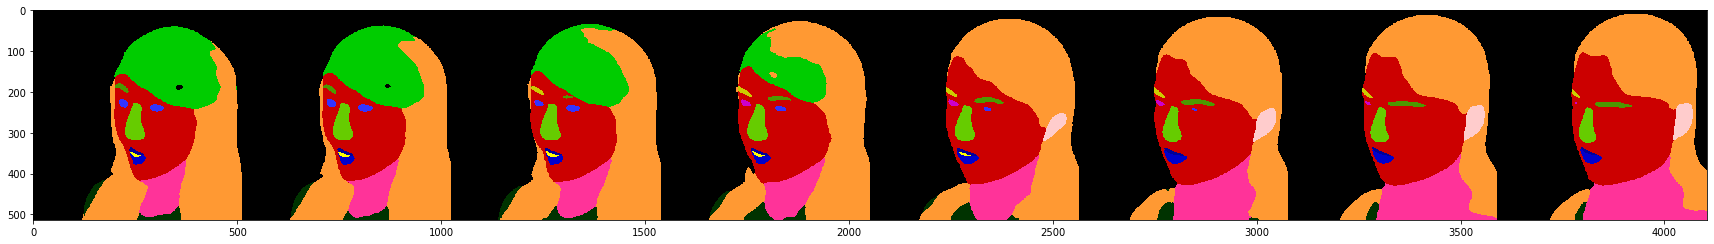

1 torch.Size([8, 4, 4]) torch.Size([8, 4, 4]) torch.Size([8, 16384, 2])


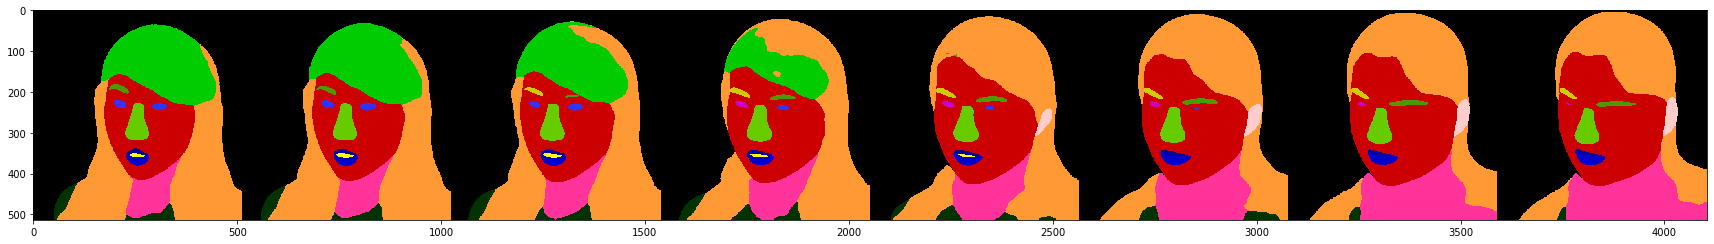

2 torch.Size([8, 4, 4]) torch.Size([8, 4, 4]) torch.Size([8, 16384, 2])


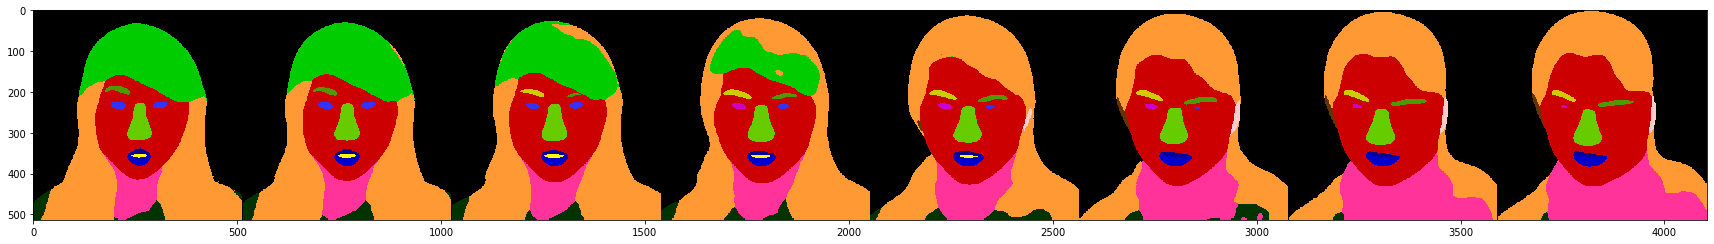

3 torch.Size([8, 4, 4]) torch.Size([8, 4, 4]) torch.Size([8, 16384, 2])


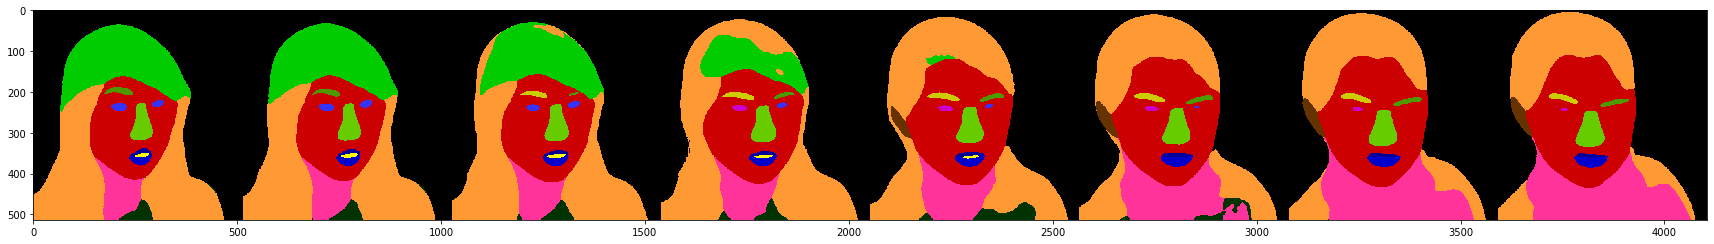

4 torch.Size([8, 4, 4]) torch.Size([8, 4, 4]) torch.Size([8, 16384, 2])


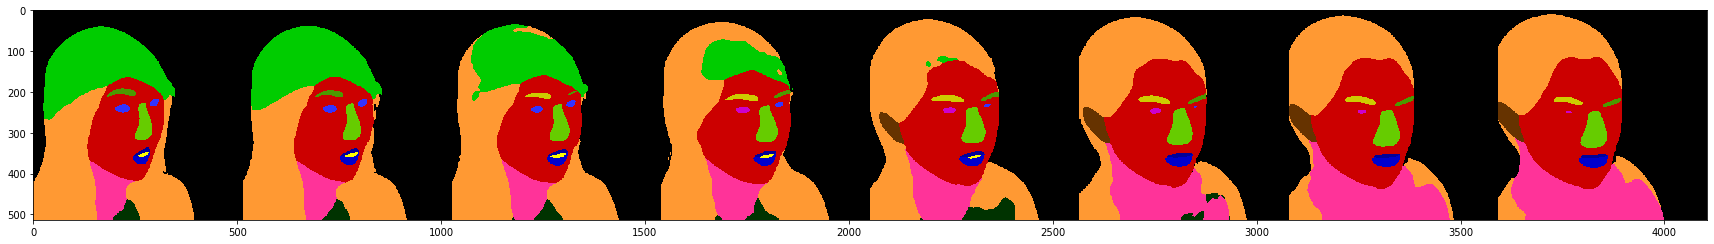

5 torch.Size([8, 4, 4]) torch.Size([8, 4, 4]) torch.Size([8, 16384, 2])


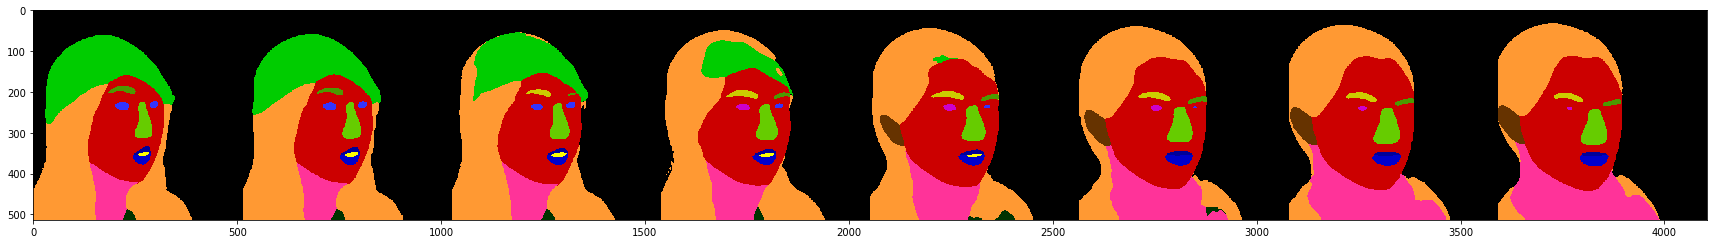

6 torch.Size([8, 4, 4]) torch.Size([8, 4, 4]) torch.Size([8, 16384, 2])


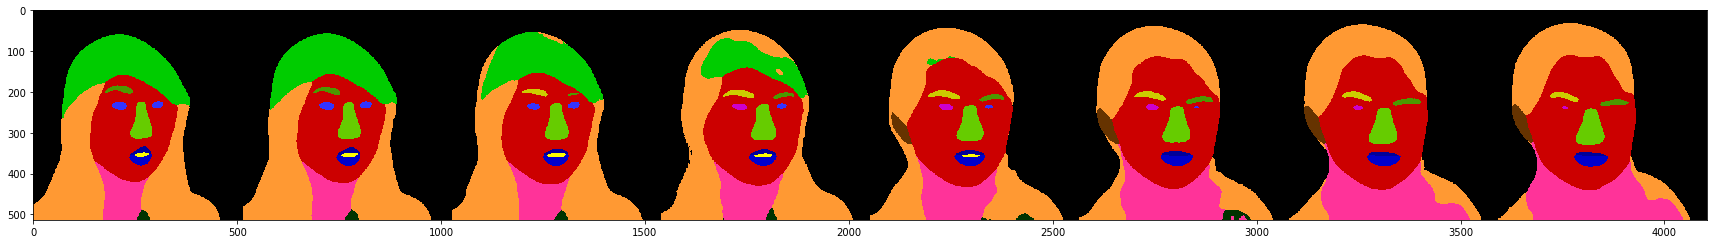

7 torch.Size([8, 4, 4]) torch.Size([8, 4, 4]) torch.Size([8, 16384, 2])


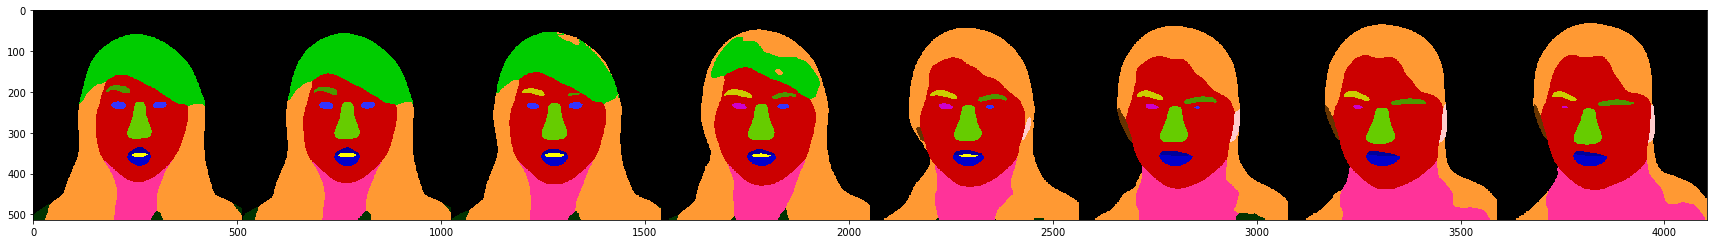

8 torch.Size([8, 4, 4]) torch.Size([8, 4, 4]) torch.Size([8, 16384, 2])


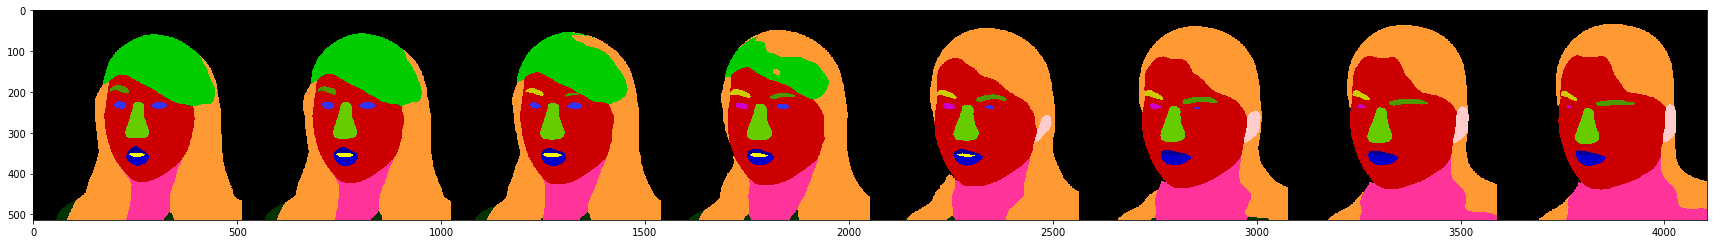

9 torch.Size([8, 4, 4]) torch.Size([8, 4, 4]) torch.Size([8, 16384, 2])


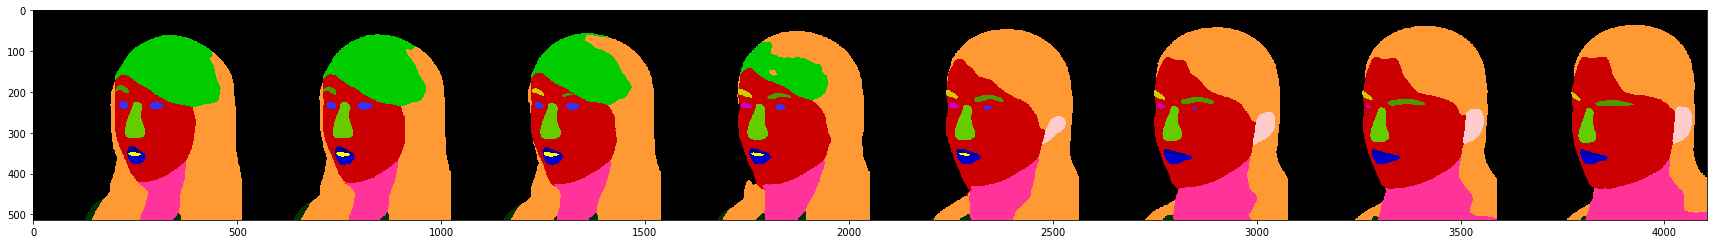

10 torch.Size([8, 4, 4]) torch.Size([8, 4, 4]) torch.Size([8, 16384, 2])


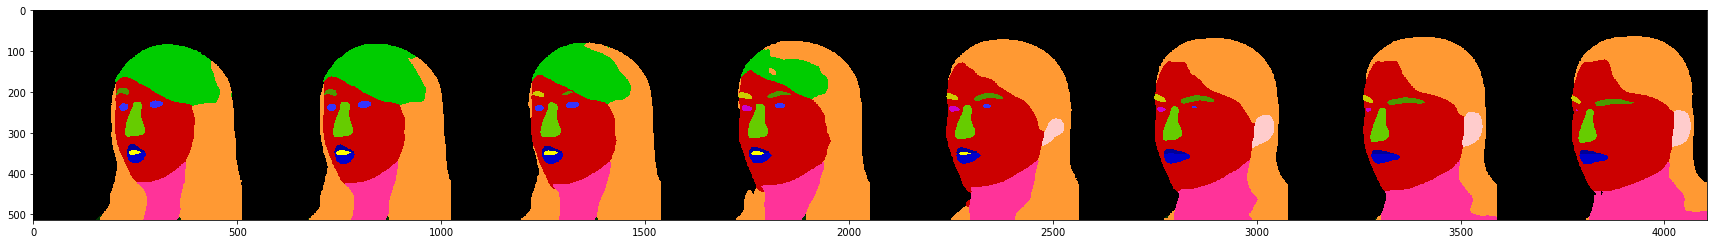

11 torch.Size([8, 4, 4]) torch.Size([8, 4, 4]) torch.Size([8, 16384, 2])


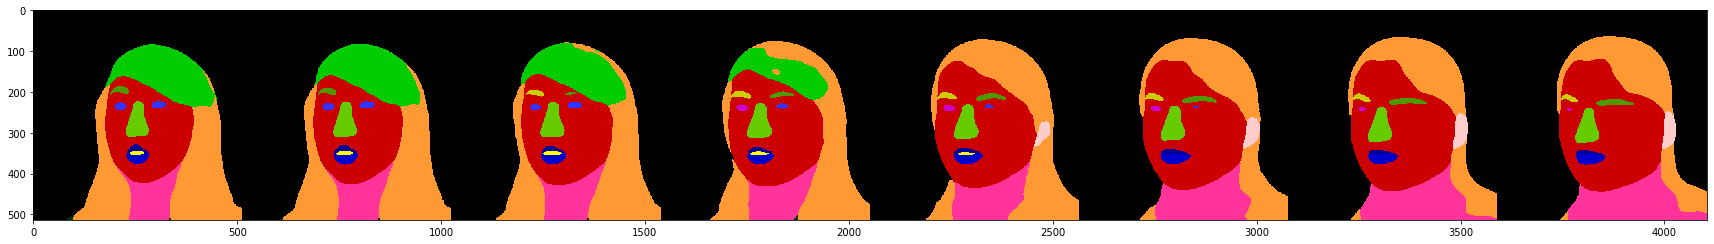

12 torch.Size([8, 4, 4]) torch.Size([8, 4, 4]) torch.Size([8, 16384, 2])


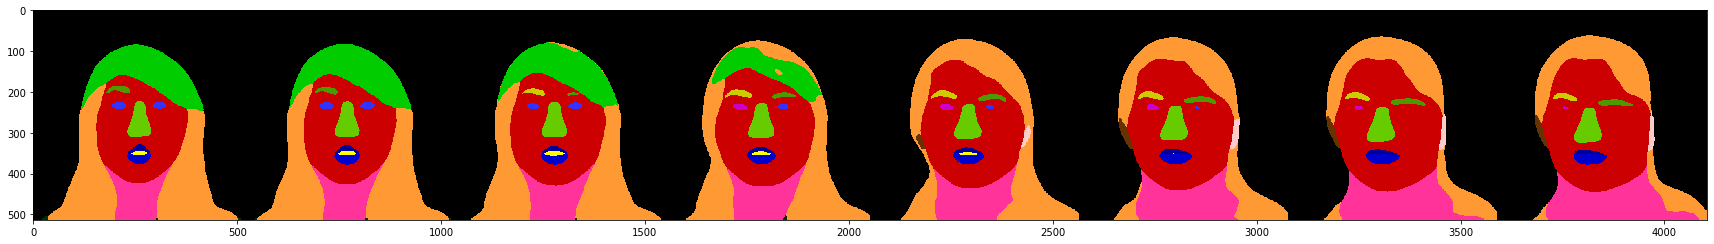

13 torch.Size([8, 4, 4]) torch.Size([8, 4, 4]) torch.Size([8, 16384, 2])


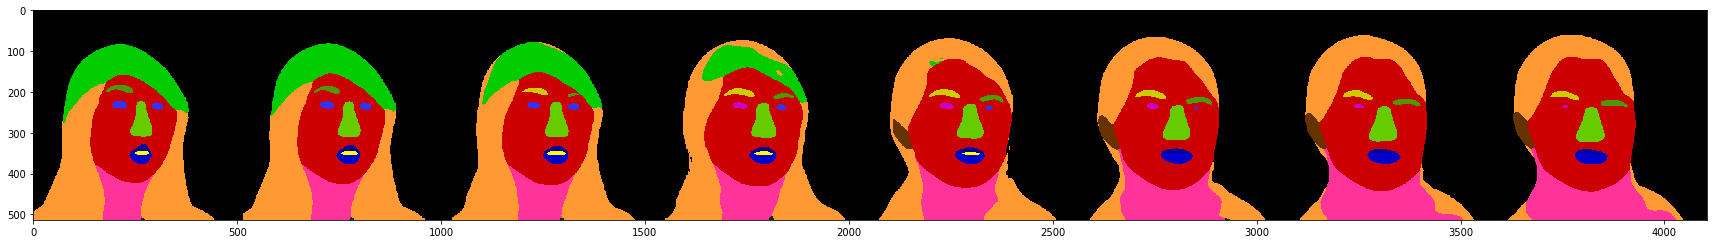

14 torch.Size([8, 4, 4]) torch.Size([8, 4, 4]) torch.Size([8, 16384, 2])


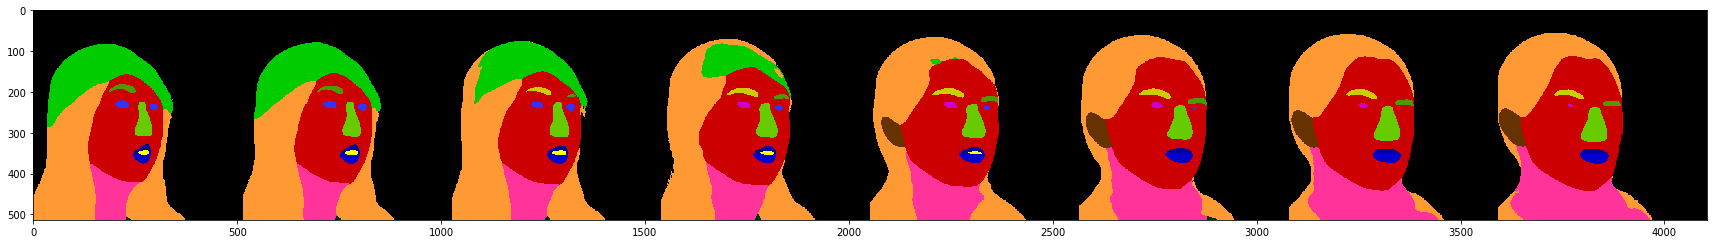

15 torch.Size([8, 4, 4]) torch.Size([8, 4, 4]) torch.Size([8, 16384, 2])


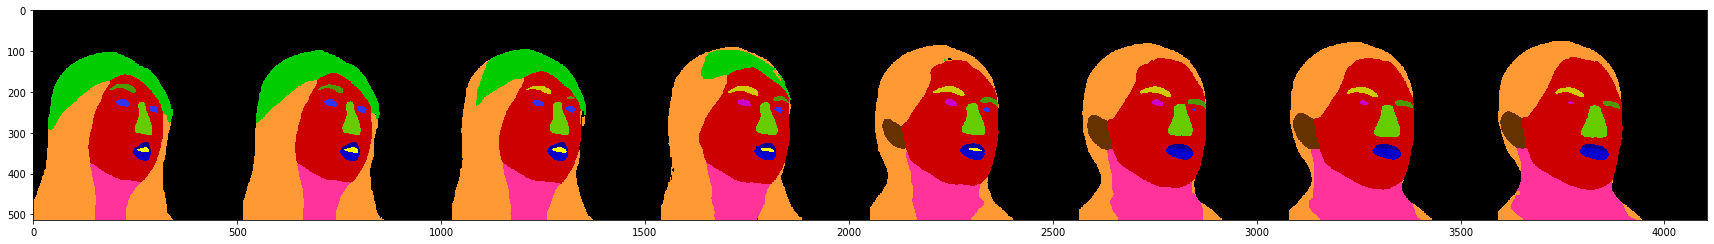

16 torch.Size([8, 4, 4]) torch.Size([8, 4, 4]) torch.Size([8, 16384, 2])


In [ ]:
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import os

matplotlib.rcParams['figure.figsize'] = [30, 5]

cam2worlds = []

with torch.no_grad():
    instance_idx = 0
        
    for idx, model_input in enumerate(dataloader):
        model_input, ground_truth = model_input
        pose = model_input['pose'].repeat(num_interps, 1, 1)
        intrinsics = model_input['intrinsics'].repeat(num_interps, 1, 1)
        uv = model_input['uv'].repeat(num_interps, 1, 1)
        
        print(idx, pose.shape, intrinsics.shape, uv.shape)
        cam2worlds.append(pose[0])
        
        predictions, depth_map = model(pose, z_interp, intrinsics, uv)
        
        B, _, C = predictions.shape
                
        pred = torch.argmax(predictions, dim=2, keepdim=True)
        output_img = util.lin2img(pred, color_map=dataset.color_map)
        output_img = make_grid(output_img, nrow=8, padding=1).permute((1, 2, 0)).cpu().numpy()
        
#         print(idx, output_img.shape, type(output_img), np.max(output_img))
        
        plt.imshow(output_img)
        plt.show()
        

In [20]:
cam2world = np.expand_dims(cam2worlds[7].cpu().numpy(), axis=0)
# print(cam2world)

np.save('/data/anpei/facial-data/seg_video/0000/cam2world.npy', cam2world)

import shutil
from glob import glob

cams = np.load('/data/anpei/facial-data/seg_video/0000/cams.npy', allow_pickle=True)

for cam in cams:
    

for dst_dir in glob(os.path.join('/data/anpei/facial-data/seg_video/fake', '[0-9]*')):
    print(dst_dir)
    np.save(os.path.join(dst_dir, 'cam2world.npy'), cam2world)

/data/anpei/facial-data/seg_video/fake/0004
/data/anpei/facial-data/seg_video/fake/0044
/data/anpei/facial-data/seg_video/fake/0019
/data/anpei/facial-data/seg_video/fake/0020
/data/anpei/facial-data/seg_video/fake/0095
/data/anpei/facial-data/seg_video/fake/0003
/data/anpei/facial-data/seg_video/fake/0084
/data/anpei/facial-data/seg_video/fake/0072
/data/anpei/facial-data/seg_video/fake/0083
/data/anpei/facial-data/seg_video/fake/0067
/data/anpei/facial-data/seg_video/fake/0056
/data/anpei/facial-data/seg_video/fake/0092
/data/anpei/facial-data/seg_video/fake/0075
/data/anpei/facial-data/seg_video/fake/0031
/data/anpei/facial-data/seg_video/fake/0000
/data/anpei/facial-data/seg_video/fake/0016
/data/anpei/facial-data/seg_video/fake/0068
/data/anpei/facial-data/seg_video/fake/0047
/data/anpei/facial-data/seg_video/fake/0035
/data/anpei/facial-data/seg_video/fake/0023
/data/anpei/facial-data/seg_video/fake/0059
/data/anpei/facial-data/seg_video/fake/0040
/data/anpei/facial-data/seg_vide

In [20]:
from seg_sampler import FaceSegSampler

sampler = FaceSegSampler()
print(sampler.uv.shape, sampler.intrinsics.shape)

smp_ins = sampler.sample_ins(100)
print(smp_ins.shape)


torch.Size([16384, 2]) torch.Size([4, 4])
(100, 1, 512, 512)


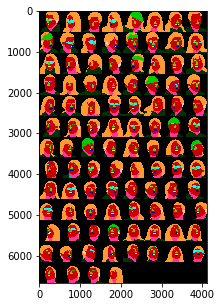

In [21]:
import sys,os
import configargparse

import torch
import numpy as np

from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [100, 5]

import util

_COLOR_MAP = np.asarray([[0, 0, 0], [204, 0, 0], [76, 153, 0], [204, 204, 0], [51, 51, 255], [204, 0, 204], [0, 255, 255], [255, 204, 204], [102, 51, 0], [
                        255, 0, 0], [102, 204, 0], [255, 255, 0], [0, 0, 153], [0, 0, 204], [255, 51, 153], [0, 204, 204], [0, 51, 0], [255, 153, 51], [0, 204, 0]])

_COLOR_MAP = torch.tensor(_COLOR_MAP, dtype=torch.float32) / 255.0

img = torch.from_numpy(smp_ins).squeeze(1).view(100,-1).unsqueeze(2)
output_img = util.lin2img(img, color_map=_COLOR_MAP)
output_img = make_grid(output_img, nrow=8, padding=1).permute((1, 2, 0)).cpu().numpy()
        
#         print(idx, output_img.shape, type(output_img), np.max(output_img))
        
plt.imshow(output_img)
plt.show()